# Sentiment analysis

import some relevant modules

In [122]:
# import libraries
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from tensorflow import keras
import re
from keras.preprocessing.text import text_to_word_sequence
from gensim.parsing.preprocessing import remove_stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
#importing the metrics from sklearn
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [123]:
# read the files
import pandas as pd
import numpy as np
import csv
train_set = pd.read_csv("/train.tsv", sep = '\t')
dev_set = pd.read_csv("/dev.tsv",sep ='\t' )
test_set = pd.read_csv("/test.tsv",sep ='\t')
train_set.head()

,SentenceId,Phrase,Sentiment
0,1,A series of escapades demonstrating the adage ...,1
1,2,"This quiet , introspective and entertaining in...",4
2,3,"Even fans of Ismail Merchant 's work , I suspe...",1
3,4,A positively thrilling combination of ethnogra...,3
4,5,Aggressive self-glorification and a manipulati...,1


In [124]:
# reading the phrase
phrase = train_set['Phrase']
phrase.head(10)

0    A series of escapades demonstrating the adage ...
1    This quiet , introspective and entertaining in...
2    Even fans of Ismail Merchant 's work , I suspe...
3    A positively thrilling combination of ethnogra...
4    Aggressive self-glorification and a manipulati...
5    A comedy-drama of nearly epic proportions root...
6    Narratively , Trouble Every Day is a plodding ...
7    The Importance of Being Earnest , so thick wit...
8                But it does n't leave you with much .
9              You could hate it for the same reason .
Name: Phrase, dtype: object

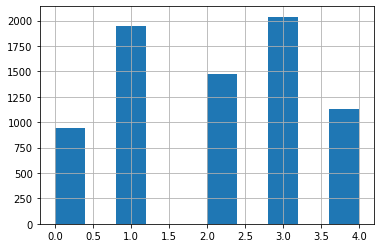

In [125]:
# reading the sentiment
sentiment = train_set["Sentiment"]
sentiment.head(10)
sentiment.hist()

# preprocess text

In [126]:
# define preprocessDataset
def preprocessDataset(text): 
        
    text = str(text)
    
    #remove single quotes 
    text = text.replace("'", "")
    
    
    #word tokenization using text-to-word-sequence
    tokenized_train_set = text_to_word_sequence(text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',split=" ")


    #stop word removal
    stop_words = set(stopwords.words('english'))
    stopwordremove = [i for i in tokenized_train_set if not i in stop_words]
    #print (stop_words)
     
    #join words into sentence
    stopwordremove_text = ' '.join(stopwordremove)
    #print(stopwordremove_text)
        
    #remove numbers
    numberremove_text = ''.join(c for c in stopwordremove_text if not c.isdigit())
    #print(output)
        
    #Stemming
    stemmer= PorterStemmer()

    stem_input=nltk.word_tokenize(numberremove_text)
    stem_text=' '.join([stemmer.stem(word) for word in stem_input])
    #print(stem_text)
    
    #lemmatization
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    lem_input = nltk.word_tokenize(stem_text)
    lem_text= ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lem_input])
    #print(lem_text)
    return lem_text


Preprocessing the train set

In [127]:
# apply preprocessing in the train set
train_set['Phrase'] = train_set['Phrase'].apply(preprocessDataset)
phrase = train_set['Phrase']
sentiment = train_set['Sentiment']
phrase.head()

0    seri escapad demonstr adag good goo also good ...
1       quiet introspect entertain independ worth seek
2    even fan ismail merchant work suspect would ha...
3    posit thrill combin ethnographi intrigu betray...
4                aggress self glorif manipul whitewash
Name: Phrase, dtype: object

Preprocessing the dev set

In [128]:
# apply preprocessing in the dev set
dev_set['Phrase'] = dev_set['Phrase'].apply(preprocessDataset)
dev_phrase = dev_set['Phrase']
dev_sentiment = dev_set['Sentiment']
dev_phrase.head()


0                                             scorcher
1    spectacular everi sen word even know orc uruk hai
2    slacker jokey approach colleg educ disappointi...
3    ok movi someth sitcom apparatu line work humor...
4                        although idea new result tire
Name: Phrase, dtype: object

Preprocessing the phrase of test set

In [129]:
# applying preprocessing in the test set
test_set['Phrase'] = test_set['Phrase'].apply(preprocessDataset)
test_phrase =test_set['Phrase']
test_set.head()


,SentenceId,Phrase
0,8545,intermitt plea mostli routin effort
1,8546,kidman realli thing worth watch birthday girl ...
2,8547,get rhythm movi becom headi experi
3,8548,kept wish watch documentari wartim navajo acco...
4,8549,kinnear nt aim sympathi rather deliv perform s...


# Naive Byes 

In [130]:
# define word collection
def wordCollection(phrase, sentiment):
    words = []
    for i in phrase[phrase['Sentiment'] == sentiment]['Phrase'].str.split():
        for j in i:
            words.append(j)
    return words

In [131]:
negative = wordCollection(train_set,0)
somewhat_negative = wordCollection(train_set,1)
neutral = wordCollection(train_set,2)
somewhat_positive = wordCollection(train_set,3)
positive = wordCollection(train_set,4)

In [132]:
# define map_3_value
def map_3_value(sentiments):
    value_scale = {
        0: 0,
        1: 0,
        2: 1,
        3: 2,
        4: 2,
    }
    
    return np.array([value_scale[sentiment] for sentiment in sentiments])


Mapping the 3 value sentimental scale in dev and train

In [133]:
# mapping 3 value sentimental scale
dev_sentiments_3 = map_3_value(dev_sentiment)
train_sentiments_3 = map_3_value(sentiment)

In [134]:
# printing it
print(list(sentiment[:20]))
print(list(train_sentiments_3[:20]))

[1, 4, 1, 3, 1, 4, 1, 3, 1, 1, 1, 1, 4, 3, 3, 3, 3, 2, 1, 2]
[0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 0, 1]


In [135]:
# def calculate_prior(sentiment,Y):
#     classes = sorted(list)
#     prior = []
#     for i in classes:
#         prior.append(len(sentiment(sentiment[Y])==i)/len(df))
#     return prior

Extracting unigrams from the word list of all the sets

In [136]:
# extract unigrams from the word list
def extract_unigrams(phrase):
  return [
    #checking for the words while extracting unigrams
    word.lower() for word in re.findall(r'\b[A-Za-z]{2,}\b', phrase)
  ]

Vocabulary list from extracted unigrams

In [137]:
# printing the list of vocab
vocab_list = { unigram for phrase_word in phrase for unigram in extract_unigrams(phrase_word) }
print(list(vocab_list)[:50])


['thandi', 'midway', 'hayse', 'bentley', 'palestinian', 'mermaid', 'oft', 'splatter', 'hepburn', 'downright', 'grandli', 'dollar', 'libidin', 'pool', 'smother', 'exactli', 'ricochet', 'scorces', 'essenc', 'molina', 'clone', 'booth', 'war', 'territori', 'progress', 'ravag', 'immun', 'pile', 'intellig', 'textur', 'seren', 'saddest', 'atyp', 'ape', 'stomach', 'drumbeat', 'campi', 'publicist', 'excus', 'revers', 'sandler', 'tact', 'horn', 'diamond', 'sprawl', 'cast', 'although', 'europ', 'guess', 'paulin']


Creating dictionary for word to vocabulary id

In [138]:
# vocab id to word dict
vocab_id_to_word_dict = dict(enumerate(vocab_list))
word_to_vocab_id_dict = {v: k for k, v in vocab_id_to_word_dict.items()}

Creating unigrams for dev, train and test sets

In [139]:
# creating unigrams for the datsets
dev_unigrams = [extract_unigrams(phrase) for phrase in dev_phrase]
train_unigrams = [extract_unigrams(phrase) for phrase in phrase]
test_unigrams = [extract_unigrams(phrase) for phrase in test_phrase]

Vectorise the unigrams

In [140]:
# define vectorise_unigram
def vectorise_unigram(data_unigrams, vocab):
    vec = []
    for unigram in data_unigrams:
        counter_unigram = Counter(unigram)
        vec.append([counter_unigram[v] for v in vocab])
    
    return np.array(vec)

Vectorising all the sets

In [141]:
# building up dev , train and test vec
dev_vec = vectorise_unigram(dev_unigrams, vocab_list)
train_vec = vectorise_unigram(train_unigrams, vocab_list)
test_vec = vectorise_unigram(test_unigrams, vocab_list)

Prior and Word Probability calculation

In [142]:
# define function to calculate prior probability for sentiment
def calculate_prior_probability_for_sentiment(sentiments):    
    counter_sentiment = Counter(sentiments)
    return np.array([v for (_, v) in sorted(counter_sentiment.items())]) / len(sentiments)

In [143]:
# define function to calculate word probability for sentiment
def calculate_word_probability_for_sentiment(total_vocab, data_unigrams, sentiments):
    probs = np.zeros((total_vocab, len(set(sentiments))))
    for i, unigram in enumerate(data_unigrams):
        for word, count in Counter(unigram).items():
            probs[word_to_vocab_id_dict[word]][sentiments[i]] += count
    # With Laplace smoothing for prob check
    return np.log10(probs[:] + 1) / (probs.sum(axis=0) + total_vocab)

Prior and Word Probability for training sentimental 3-value scale

In [144]:
# calculate prior and word prob for training set for 3-value scale
train_prob_3 = calculate_prior_probability_for_sentiment(train_sentiments_3)
word_3_prob = calculate_word_probability_for_sentiment(len(vocab), train_unigrams, train_sentiments_3)

print(train_prob_3, '\n')
print(word_3_prob)

[0.38331784 0.19577633 0.42090583] 

[[0.00000000e+00 1.30434592e-05 0.00000000e+00]
 [8.06964389e-06 0.00000000e+00 7.31952235e-06]
 [0.00000000e+00 1.30434592e-05 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 7.31952235e-06]
 [0.00000000e+00 0.00000000e+00 1.16011684e-05]
 [0.00000000e+00 0.00000000e+00 7.31952235e-06]]


In [145]:
# calculate prior and word probability for training set for 5-value scale
train_prob_5 = calculate_prior_probability_for_sentiment(sentiment)
word_5_prob = calculate_word_probability_for_sentiment(len(vocab), train_unigrams, sentiment)

print(train_prob_5, '\n')
print(word_5_prob)

[0.12471776 0.25860008 0.19577633 0.27068668 0.15021915] 

[[0.00000000e+00 0.00000000e+00 1.30434592e-05 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.05765581e-05 0.00000000e+00 9.98110065e-06
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.30434592e-05 0.00000000e+00
  0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.98110065e-06
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.58196702e-05
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.98110065e-06
  0.00000000e+00]]


Predicting sentiment

In [146]:
# define function for predicting the sentiment
def predict_sentiment(prior_prob, word_prob, data_vec):
  return np.argmax(data_vec.dot(prior_prob * word_prob), axis=1)

Predicting sentiment for 3-value and 5-value scale and scores associated with it. 

In [147]:
# 3-value sentiment scale for dev and confusion matrix for the predicted and actual dev sentimental 3 value scale
dev_pred_sentiment_3 = predict_sentiment(train_prob_3, word_3_prob, dev_vec)
confusion_matrix(dev_sentiments_3, dev_pred_sentiment_3)


array([[263,   0, 123],
       [ 72,   1, 108],
       [ 64,   0, 369]])

In [148]:
# metrics
print('Accuracy:', accuracy_score(dev_sentiments_3, dev_pred_sentiment_3))
print('Precision:', precision_score(dev_sentiments_3, dev_pred_sentiment_3, average='macro'))
print('Recall:', recall_score(dev_sentiments_3, dev_pred_sentiment_3, average='macro'))
print('F1-score:', f1_score(dev_sentiments_3, dev_pred_sentiment_3, average='macro'))

Accuracy: 0.633
Precision: 0.7580492898913951
Recall: 0.5130220025061942
F1-score: 0.4651589043336535


In [149]:
# 3-value sentiment scale for train and confusion matrix for the predicted and actual train sentimental 3 value scale
train_pred_sentiment_3 = predict_sentiment(train_prob_3, word_3_prob, train_vec)
confusion_matrix(train_sentiments_3, train_pred_sentiment_3)


array([[2514,    1,  371],
       [ 593,   32,  849],
       [ 139,    0, 3030]])

In [150]:
# metrics
print('Accuracy:', accuracy_score(train_sentiments_3, train_pred_sentiment_3))
print('Precision:', precision_score(train_sentiments_3, train_pred_sentiment_3, average='macro'))
print('Recall:', recall_score(train_sentiments_3, train_pred_sentiment_3, average='macro'))
print('F1-score:', f1_score(train_sentiments_3, train_pred_sentiment_3, average='macro'))

Accuracy: 0.7406030017266569
Precision: 0.8190432760792662
Recall: 0.6163163625285016
F1-score: 0.5597503385205003


In [151]:
# 5-value sentiment scale for train and confusion matrix for the predicted and actual train sentimental 5 value scale
train_pred_sentiment_5 = predict_sentiment(train_prob_5, word_5_prob, train_vec)
confusion_matrix(sentiment, train_pred_sentiment_5)

array([[  21,  699,    3,  216,    0],
       [   4, 1767,    2,  173,    1],
       [   7,  595,  215,  655,    2],
       [   2,  124,    0, 1911,    1],
       [   0,  157,    3,  950,   21]])

In [152]:
# metrics
print('Accuracy:', accuracy_score(sentiment, train_pred_sentiment_5))
print('Precision:', precision_score(sentiment, train_pred_sentiment_5, average='macro'))
print('Recall:', recall_score(sentiment, train_pred_sentiment_5, average='macro'))
print('F1-score:', f1_score(sentiment, train_pred_sentiment_5, average='macro'))

Accuracy: 0.52264576969053
Precision: 0.6879741065553049
Recall: 0.40640550771243833
F1-score: 0.32883495209517594


In [153]:
# predicting 5-value sentimental scale 
dev_pred_sentiment_5 = predict_sentiment(train_prob_5, word_5_prob, dev_vec)
confusion_matrix(dev_sentiment, dev_pred_sentiment_5)

array([[  0,  97,   1,  35,   0],
       [  2, 173,   3,  75,   0],
       [  1,  83,   4,  93,   0],
       [  4,  66,   1, 212,   0],
       [  0,  24,   0, 125,   1]])

In [154]:
# metrics
print('Accuracy:', accuracy_score(dev_sentiment, dev_pred_sentiment_5))
print('Precision:', precision_score(dev_sentiment, dev_pred_sentiment_5, average='macro'))
print('Recall:', recall_score(dev_sentiment, dev_pred_sentiment_5, average='macro'))
print('F1-score:', f1_score(dev_sentiment, dev_pred_sentiment_5, average='macro'))

Accuracy: 0.39
Precision: 0.44551124487919064
Recall: 0.2923354376714985
F1-score: 0.2135330136821063


Predicting Test set

In [155]:
# predicting test sentiment of 3-value scale
test_pred_sentiments_3 = predict_sentiment(train_prob_3, word_3_prob, test_vec)
test_pred_sentiments_3

array([2, 2, 2, ..., 2, 0, 0])

In [156]:
# predicitng test sentiment of 5-value scale
test_pred_sentiments_5 = predict_sentiment(train_prob_5, word_5_prob, test_vec)
test_pred_sentiments_5

array([3, 3, 3, ..., 3, 1, 1])